In [1]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)
#config.update('jax_debug_nans', True) #this checks outputs for nans everytime and reruns the function with non-optimized mode.


import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)
from NODE_fns import NODE_old as NODE, sigma_split as sigma_NODE
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import cond, scan
from jax.experimental.ode import odeint
from diffrax import diffeqsolve, ODETerm, SaveAt, Heun as mysolver
import pickle
key = random.PRNGKey(0)
import jax

In [2]:
with open('saved/phi_norm_w.npy', 'rb') as f:
    [inp_stds, out_stds] = pickle.load(f)
[inp_std1, inp_std2, inp_std3, inp_std4, inp_std5] = inp_stds
[out_std1, out_std2, out_std3, out_std4, out_std5] = out_stds
with open('saved/phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = Phi_params

In [3]:
# dΦ/dtau_NEQ
# Govindjee Φ
def dPhi_gov(tau_i, etad = 1360, etav = 175000): #This function takes in tau matrix and spits out dphidtau
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]

# N-ODE based Φ
def dPhi_NODE(taui, Phi_params):
    NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = Phi_params
    
    tau1 = taui[0]
    tau2 = taui[1]
    tau3 = taui[2]

    I1 = tau1
    I2 = tau1 + tau2
    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

    I1 = I1/inp_std1
    I2 = I2/inp_std2
    I3 = I3/inp_std3
    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N1 = NODE(I1, NODE1_params)
    N2 = NODE(I2, NODE2_params)
    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = N1*out_std1
    N2 = N2*out_std2
    N3 = N3*out_std3
    N4 = N4*out_std4
    N5 = N5*out_std5

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    return [Phi1, Phi2, Phi3]

In [4]:
def tau_NEQ(lm1e, lm2e, lm3e, mu_m, alpha_m, K_m):
    Je = lm1e*lm2e*lm3e
    
    b1 = Je**(-2/3)*lm1e**2
    b2 = Je**(-2/3)*lm2e**2
    b3 = Je**(-2/3)*lm3e**2

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*(K_m*10000)/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    return tau_A

def tau_NEQ_NODE(lm1, lm2, lm3, Psi_neq_params):
    J = lm1*lm2*lm3
    sigma_NEQ = sigma_NODE(lm1, lm2, lm3, Psi_neq_params)
    tau_NEQ = J*sigma_NEQ
    return tau_NEQ

def sigma(inputs, params):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = inputs
    # Psi_eq_params, Psi_neq_params, Phi_params = params
    alpha_m, mu_m, K_m, eta_D, eta_V, K, mu = params
    J = lm1*lm2*lm3
    Je = lm1e*lm2e*lm3e
    
    b1 = Je**(-2/3)*lm1e**2
    b2 = Je**(-2/3)*lm2e**2
    b3 = Je**(-2/3)*lm3e**2

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*(K_m*10000)/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    tau_NEQ = np.array([[tau_A[0], 0, 0],
                        [0, tau_A[1], 0],
                        [0, 0, tau_A[2]]]) #Since stress and strain are coaxial in the isotropic case

    sigma_NEQ = 1/Je*tau_NEQ
    b = np.array([[lm1**2, 0, 0],
                  [0, lm2**2, 0],
                  [0, 0, lm3**2]])

    sigma_EQ = mu/J*(b-np.eye(3)) + 2*(K*10000)*(J-1)*np.eye(3)
    # sigma_EQ  = sigma_NODE(lm1, lm2, lm3, Psi_eq_params)
    # sigma_NEQ = sigma_NODE(lm1e, lm2e, lm3e, Psi_neq_params)
    sigma = sigma_NEQ + sigma_EQ
    return sigma
getsigma = vmap(sigma, in_axes=(0, None), out_axes=0)

dsigma33 = grad(lambda inputs, params: sigma(inputs,params)[2,2])

In [5]:
def yprime(y, t, lm1dot, tpeak, params):
    # Psi_eq_params, Psi_neq_params, Phi_params = params
    alpha_m, mu_m, K_m, eta_D, eta_V, K, mu = params
    lm1, lm2, lm3, lm1e, lm2e, lm3e = y
    
    true_fun  = lambda t: np.array(lm1dot)
    false_fun = lambda t: np.array(   0.0)
    lm1dot = cond(t<tpeak, true_fun, false_fun, t)

    tau_A = tau_NEQ(lm1e, lm2e, lm3e, mu_m, alpha_m, K_m) 
    # tau_A = tau_NEQ_NODE(lm1e, lm2e, lm3e, Psi_neq_params) 
    # tau_A = np.array([tau_A[0,0], tau_A[1,1], tau_A[2,2]])
    # dphidtaui = dPhi_NODE(tau_A, Phi_params)
    dphidtaui = dPhi_gov(tau_A, eta_D, eta_V)

    lm1edot = (lm1dot/lm1 - 0.5*dphidtaui[0])*lm1e
    lm2edot = np.array(-0.5*dphidtaui[1]*lm2e)
    lm3edot = np.array(-0.5*dphidtaui[2]*lm3e)

    lm2dot = lm3dot = np.array(0)
    
    return lm1dot, lm2dot, lm3dot, lm1edot, lm2edot, lm3edot

In [6]:
@jit
def biaxial_visco(params, time, lamb):
    ipeak = np.argmax(np.abs(np.around(lamb, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    tpeak = time[ipeak]
    lambpeak = lamb[ipeak]

    lambdot = (lambpeak-1.0)/tpeak

    # y0 = [1.0,1.0,1.0,1.0,1.0,1.0]
    # yprime2 = lambda y, t: yprime(y,t,lm1dot,lm2dot,tpeak,params)
    # lm1, lm2, lm3, lm1e, lm2e, lm3e = odeint(yprime2, y0, time)
    
    yprime2 = lambda t, y, args: np.array(yprime(y,t,lambdot,tpeak,params))
    term = ODETerm(yprime2)
    solver = mysolver()
    y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time)
    solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=1, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()
    
    sig = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], params)
    return sig, lm1, lm2, lm3, lm1e, lm2e, lm3e

In [7]:
# Material parameters:
mu_m = np.array([51.4, -18, 3.86])
alpha_m = np.array([1.8, -2, 7])
K_m = 1.0
tau = 17.5
shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
eta_D = tau*shear_mod
eta_V = tau*(K_m*10000)
mu = 77.77 #=shear_mod
K = 1.0
params = alpha_m, mu_m, K_m, eta_D, eta_V, K, mu

In [8]:
with open('training_data/P01.npy','rb') as f:
    time, lamb, sigm = pickle.load(f)
test, lm1, lm2, lm3, lm1e, lm2e, lm3e = biaxial_visco(params, time[0,:], lamb[0,:])

In [10]:
@jit
def loss(params, time, lm1, sigma):
    sigma_pr,_,_,_,_,_,_ = biaxial_visco(params, time, lm1)
    loss = np.sqrt((sigma_pr[:,0,0]-sigma[:])**2)
    return loss/lm1.shape[0]
loss_vmap = vmap(loss, in_axes=(None, 0, 0, 0), out_axes=0)

def batch_loss(params, time, lm1, sigma):
    loss = loss_vmap(params, time, lm1, sigma)
    loss = np.mean(loss)
    return loss

@partial(jit, static_argnums=(0,))
def step(loss_fn, i, opt_state, X1_batch, X2_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, X1_batch, X2_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(X1, X2, Y, opt_state, key, nIter = 1000, batch_size=10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, X1.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(batch_loss, it, opt_state, X1[i], X2[i], Y[i])
        if it % 10 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, X1[i], X2[i], Y[i])
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

In [11]:
with open('training_data/P01.npy','rb') as f:
    time, lamb, sigm = pickle.load(f)

In [17]:
opt_init, opt_update, get_params = optimizers.adam(1.0e-5)
opt_state = opt_init(params)

params, train_loss, val_loss = train(time, lamb, sigm, opt_state, key, nIter = 100, batch_size=2)
with open('saved/P01_gov_params.npy', 'wb') as f:
    pickle.dump(params, f)

it 0, train loss = 1.695827e-02
it 10, train loss = 5.889514e-03
it 20, train loss = 5.266678e-03
it 30, train loss = 5.207123e-03
it 40, train loss = 5.041530e-03
it 50, train loss = 4.930035e-03
it 60, train loss = 4.913309e-03
it 70, train loss = 4.912833e-03
it 80, train loss = 4.909765e-03
it 90, train loss = 4.907688e-03
it 100, train loss = 4.907605e-03


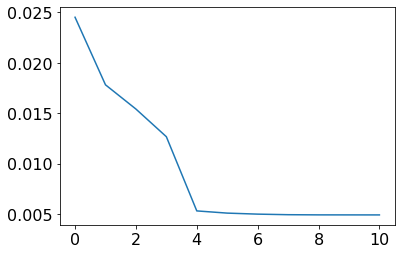

In [15]:
fig, ax = plt.subplots()
ax.plot(train_loss)

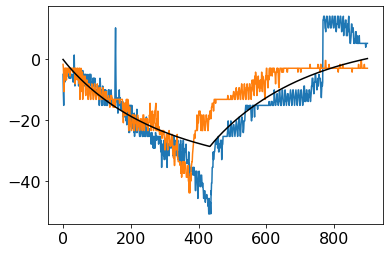

In [20]:
test, lm1, lm2, lm3, lm1e, lm2e, lm3e = biaxial_visco(params, time[0,:], lamb[0,:])
plt.plot(time[0,:], sigm[0,:])
plt.plot(time[1,:], sigm[1,:])
plt.plot(time[0,:], test[:,0,0],'k')

In [21]:
with open('saved/P01_gov_params.npy', 'wb') as f:
    pickle.dump(params, f)

## Testing

In [15]:
with open('saved/params_retrained.npy', 'rb') as f:
    params = pickle.load(f)

sigx_err = []
sigy_err = []
for j in range(time.shape[0]):
    t = time[j]
    lm1 = lmb_x[j]
    lm2 = lmb_y[j]
    sigx = sgm_x[j]
    sigy = sgm_y[j]
    sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, t, lm1, lm2)
    sigx_err.append(np.abs(sig[:,0,0]-sgm_x[j]))
    sigy_err.append(np.abs(sig[:,0,0]-sgm_x[j]))

sigx_err = np.array(sigx_err)
sigy_err = np.array(sigy_err)
err = np.mean(np.array([sigx_err, sigy_err]), axis=0)
norm = np.max(err)
err_after = err/norm
err_after = err_after[::4]

In [13]:
with open('saved/phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/Psi_eq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = onp.load(f)
params = [Psi_eq_params, Psi_neq_params, Phi_params]

sigx_err = []
sigy_err = []
for j in range(time.shape[0]):
    t = time[j]
    lm1 = lmb_x[j]
    lm2 = lmb_y[j]
    sigx = sgm_x[j]
    sigy = sgm_y[j]
    sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, t, lm1, lm2)
    sigx_err.append(np.abs(sig[:,0,0]-sgm_x[j]))
    sigy_err.append(np.abs(sig[:,0,0]-sgm_x[j]))

sigx_err = np.array(sigx_err)
sigy_err = np.array(sigy_err)
err = np.mean(np.array([sigx_err, sigy_err]), axis=0)
err_before = err/norm
err_before = err_before[::4]

Max error =  57.612241061801456


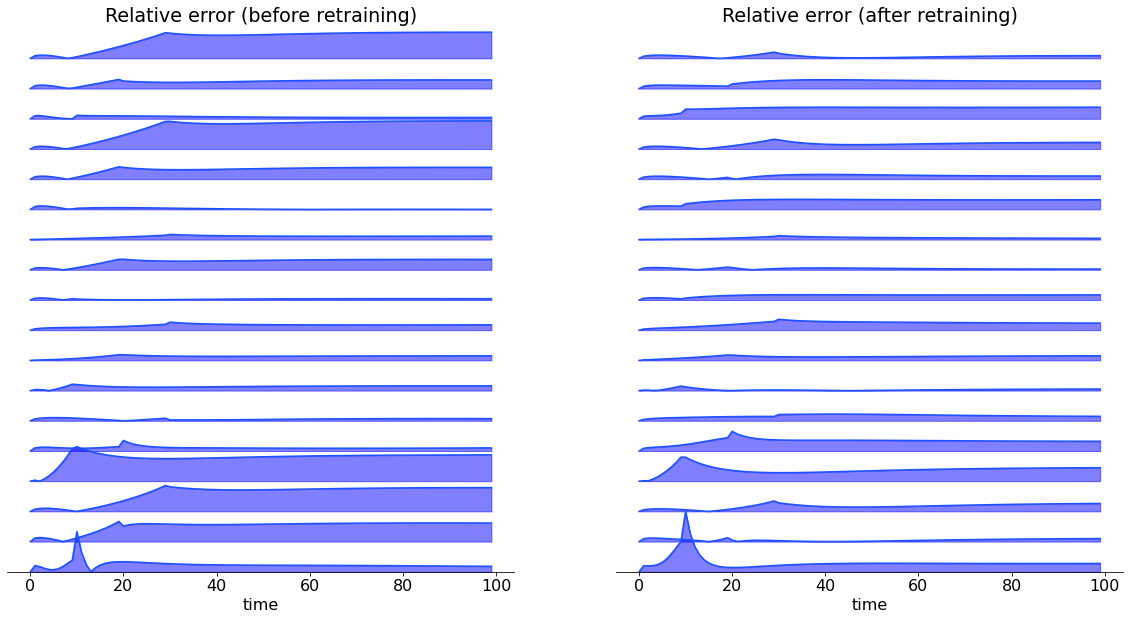

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set(ylim=[0, err_before.shape[0]/2], yticks=[], xlabel='time', title='Relative error (before retraining)')
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)


ax[1].set(ylim=[0, err_before.shape[0]/2], yticks=[], xlabel='time', title='Relative error (after retraining)')
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)

for i in range(err_before.shape[0]):
    ax[0].plot(time[0], err_before[i]+i/2, '#1a53ff')
    zr = np.zeros(100) + i/2
    ax[0].fill_between(time[0], zr, err_before[i]+i/2, color='b', alpha=0.5)

    ax[1].plot(time[0], err_after[i]+i/2, '#1a53ff')
    zr = np.zeros(100) + i/2
    ax[1].fill_between(time[0], zr, err_after[i]+i/2, color='b', alpha=0.5)
print("Max error = ", norm)
pass

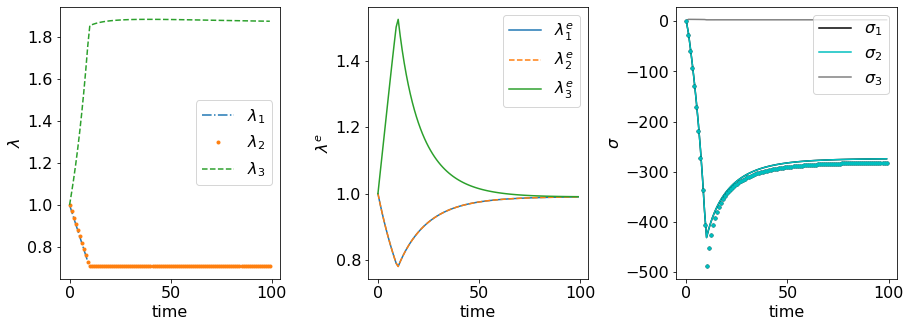

In [16]:
j = 0
i = 100
t = time[j,:i]
lm1 = lmb_x[j,:i]
lm2 = lmb_y[j,:i]
sigx = sgm_x[j,:i]
sigy = sgm_y[j,:i]
sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, t, lm1, lm2)

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)

ax[0].plot(t, lm1, '-.',label='$\lambda_1$')
ax[0].plot(t, lm2, '.',label='$\lambda_2$')
ax[0].plot(t, lm3, '--',label='$\lambda_3$')
ax[0].set(xlabel='time', ylabel='$\lambda$')
ax[0].legend() 

ax[1].plot(t, lm1e, label='$\lambda_1^e$')
ax[1].plot(t, lm2e, '--', label='$\lambda_2^e$')
ax[1].plot(t, lm3e, label='$\lambda_3^e$')
ax[1].set(xlabel='time', ylabel='$\lambda^e$')
ax[1].legend()

ax[2].plot(t, sig[:,0,0], 'k-',label='$\sigma_1$')
ax[2].plot(t, sig[:,1,1], 'c-',label='$\sigma_2$')
ax[2].plot(t, sig[:,2,2], 'gray',label='$\sigma_3$')
ax[2].plot(t, sigx, 'k.')
ax[2].plot(t, sigy, 'c.')
ax[2].set(xlabel='time', ylabel='$\sigma$')
ax[2].legend(loc='upper right') 
pass

In [ ]:
j = 2
i = 100
t = time[j,:i]
lm1 = lmb_x[j,:i]
lm2 = lmb_y[j,:i]
sigx = sgm_x[j,:i]
sigy = sgm_y[j,:i]
sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, t, lm1, lm2)

t2 = np.linspace(t[0], t[-1], lm3.shape[0])

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)

ax[0].plot(t2, lm1, '-.',label='$\lambda_1$')
ax[0].plot(t2, lm2, '.',label='$\lambda_2$')
ax[0].plot(t2, lm3, '--',label='$\lambda_3$')
ax[0].set(xlabel='time', ylabel='$\lambda$')
ax[0].legend() 

ax[1].plot(t2, lm1e, label='$\lambda_1^e$')
ax[1].plot(t2, lm2e, '--', label='$\lambda_2^e$')
ax[1].plot(t2, lm3e, label='$\lambda_3^e$')
ax[1].set(xlabel='time', ylabel='$\lambda^e$')
ax[1].legend()

ax[2].plot(t2, sig[:,0,0], 'k-',label='$\sigma_1$')
ax[2].plot(t2, sig[:,1,1], 'c-',label='$\sigma_2$')
ax[2].plot(t2, sig[:,2,2], 'gray',label='$\sigma_3$')
ax[2].plot(t, sigx, 'k.')
ax[2].plot(t, sigy, 'c.')
ax[2].set(xlabel='time', ylabel='$\sigma$')
ax[2].legend(loc='upper right') 
pass

In [ ]:
j = 0
i = 100
t = time[j,:i]
lm1 = lmb_x[j,:i]
lm2 = lmb_y[j,:i]
sigx = sgm_x[j,:i]
sigy = sgm_y[j,:i]
sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, t, lm1, lm2, 10)

t2 = np.linspace(t[0], t[-1], lm3.shape[0])

# lm1i = lm1/lm1e
# lm2i = lm2/lm2e
# lm3i = lm3/lm3e

# tau_A = vmap(tau_NEQ)(lm1e,lm2e,lm3e)
# J = lm1*lm2*lm3
# sigma_EQ11 = mu/J*(lm1**2-1) + 2*K*(J-1)
# sigma_EQ22 = mu/J*(lm2**2-1) + 2*K*(J-1)
# sigma_EQ33 = mu/J*(lm3**2-1) + 2*K*(J-1)

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)

ax[0].plot(t2, lm1, '-.',label='$\lambda_1$')
ax[0].plot(t2, lm2, '.',label='$\lambda_2$')
ax[0].plot(t2, lm3, '--',label='$\lambda_3$')
ax[0].set(xlabel='time', ylabel='$\lambda$')
ax[0].legend() 

ax[1].plot(t2, lm1e, label='$\lambda_1^e$')
ax[1].plot(t2, lm2e, '--', label='$\lambda_2^e$')
ax[1].plot(t2, lm3e, label='$\lambda_3^e$')
ax[1].set(xlabel='time', ylabel='$\lambda^e$')
ax[1].legend()

# ax[0,2].plot(t, lm1i, label='$\lambda_1^i$')
# ax[0,2].plot(t, lm2i, label='$\lambda_2^i$')
# ax[0,2].plot(t, lm3i, label='$\lambda_3^i$')
# ax[0,2].set(xlabel='time', ylabel='$\lambda^i$')
# ax[0,2].legend()

# ax[1,0].plot(t, tau_A[:,0], label=r'$\tau_{NEQ,11}$')
# ax[1,0].plot(t, tau_A[:,1], label=r'$\tau_{NEQ,22}$')
# ax[1,0].plot(t, tau_A[:,2], label=r'$\tau_{NEQ,33}$')
# ax[1,0].set(xlabel='time', ylabel=r'$\tau_{NEQ}$')
# ax[1,0].legend()

# ax[1,1].plot(t, sigma_EQ11, label=r'$\sigma_{EQ,11}$')
# ax[1,1].plot(t, sigma_EQ22, label=r'$\sigma_{EQ,22}$')
# ax[1,1].plot(t, sigma_EQ33, label=r'$\sigma_{EQ,33}$')
# ax[1,1].set(xlabel='time', ylabel=r'$\sigma_{EQ}$')
# ax[1,1].legend()

ax[2].plot(t2, sig[:,0,0], 'k-',label='$\sigma_1$')
ax[2].plot(t2, sig[:,1,1], 'c-',label='$\sigma_2$')
ax[2].plot(t2, sig[:,2,2], 'gray',label='$\sigma_3$')
ax[2].plot(t, sigx, 'k.')
ax[2].plot(t, sigy, 'c.')
ax[2].set(xlabel='time', ylabel='$\sigma$')
ax[2].legend(loc='upper right') 

# fig.savefig('test1.jpg')
pass

Diffrax numerical solvers table

| Solver | works? | solution time |
|--------|--------|---------------|
| Dopri5 | Yes | 500 ms |
| Euler  | No  | - |
| Heun   | Yes | 175 ms |
| Midpoint | Yes | 175 ms |
| Ralston | Yes | 175 ms |
| Bosh3  | Yes | 260 ms |
| Tsit5  | Yes | 520 ms |
| Dopri8 | Yes | 1100 ms |

Among these, Heun with dt0 = 0.5 works at 36 ms.


In [10]:
import pandas as pd

In [11]:
test3 = pd.read_csv('training_data/P01_Test003Data.csv')
test5 = pd.read_csv('training_data/P01_Test005Data.csv')
test3 = test3[['SetName','Cycle','Time_S', 'Size_mm', 'Displacement_mm', 'Force_N', 'Stretch', 'Stress [kPa]', 'Disp']]
test5 = test5[['SetName','Cycle','Time_S', 'Size_mm', 'Displacement_mm', 'Force_N', 'Stretch', 'Stress [kPa]', 'Disp']]
test3 = test3.rename(columns={'Stress [kPa]':'Stress'})
test5 = test5.rename(columns={'Stress [kPa]':'Stress'})

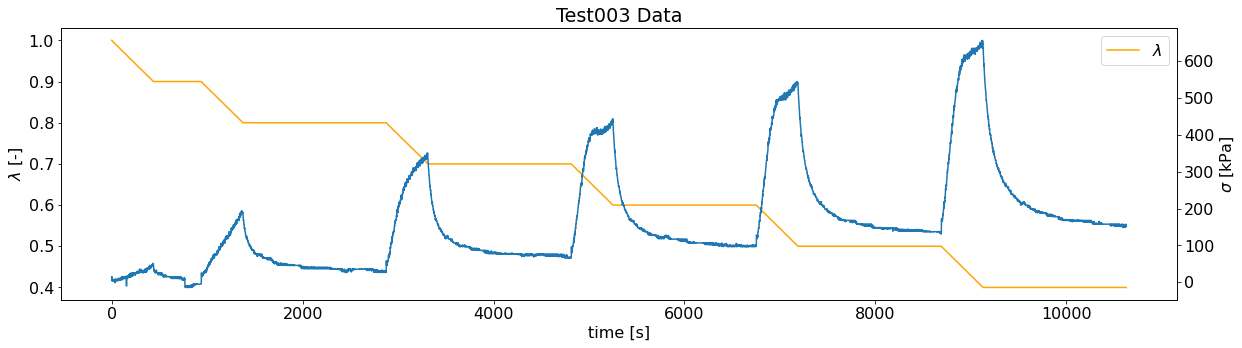

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test3['Time_S'], test3['Stretch'],'orange',label='$\lambda$')
ax.set(xlabel='time [s]', ylabel='$\lambda$ [-]', title='Test003 Data')
ax.legend()
ax2 = ax.twinx()
ax2.plot(test3['Time_S'], test3['Stress'], label='$\sigma$')
ax2.set(ylabel='$\sigma$ [kPa]')
pass

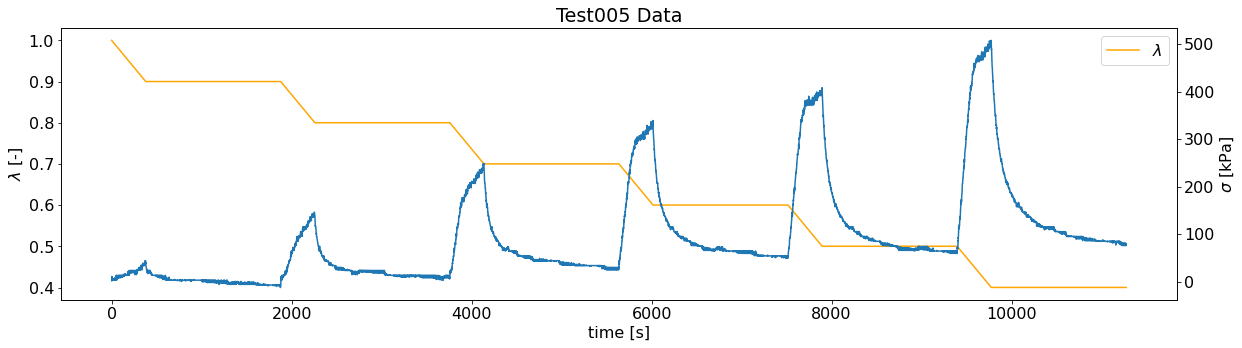

In [13]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test5['Time_S'], test5['Stretch'],'orange',label='$\lambda$')
ax.set(xlabel='time [s]', ylabel='$\lambda$ [-]', title='Test005 Data')
ax.legend()
ax2 = ax.twinx()
ax2.plot(test5['Time_S'], test5['Stress'], label='$\sigma$')
ax2.set(ylabel='$\sigma$ [kPa]')
pass

In [36]:
load = 1
idx = onp.array(test3['SetName'])
idx = np.array(idx=='Load {}'.format(load))
lm1 = np.array(test3['Stretch'])[idx]
t = np.array(test3['Time_S'])[idx]#/100


# sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, t, lm1, lm2)

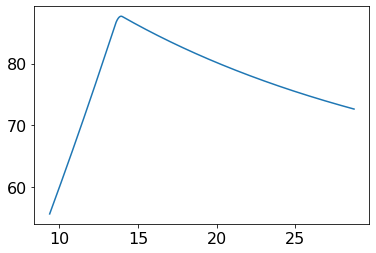

In [21]:
plt.plot(t, -sig[:,0,0])

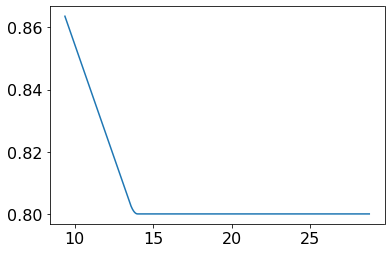

In [22]:
plt.plot(t, lm1)

In [17]:
test3['SetName'].shape

(10634,)